In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from RANSAC import RANSAC

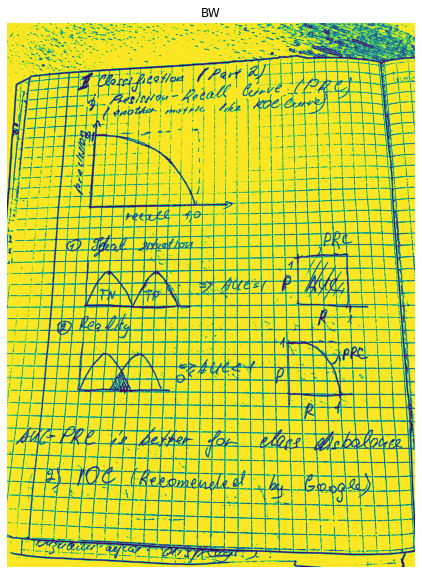

In [2]:
imagergb = cv2.imread('images/nb.jpg')
img = cv2.cvtColor(imagergb,cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

## do morph-dilate-op
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20,20))
dilated = cv2.morphologyEx(gray, cv2.MORPH_DILATE, kernel)
## do medianBlur
median = cv2.medianBlur(dilated, 5)
diff2 = 255 - cv2.subtract(median, gray)
## do normalization
normed = cv2.normalize(diff2,None, 10, 255, cv2.NORM_MINMAX )

bw = cv2.threshold(normed, 210, 255, cv2.THRESH_BINARY)[1]
plt.figure(figsize=(10,10))
plt.clf()
plt.axis("off")
plt.title("BW")
plt.imshow(bw)

edges = cv2.Canny(bw, 100, 120, apertureSize=3, L2gradient=True)

In [3]:
lines = cv2.HoughLines(edges, 1, np.pi/360, 500,)
lines_points = np.empty((len(lines), 4), dtype=int)
lines_coefs = np.empty((len(lines), 3))

for i, line in enumerate(lines):
    for rho, theta in line:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 4000*(-b))
        y1 = int(y0 + 4000*(a))
        x2 = int(x0 - 4000*(-b))
        y2 = int(y0 - 4000*(a))
        lines_points[i] = (x1, y1, x2, y2)
        lines_coefs[i] = np.cross((x1, y1, 1), (x2, y2, 1))

In [4]:
print(f"found lines: {len(lines_coefs)}")  
r = RANSAC(iters=1000, eps=0.05)
line_group1 = r.get_direction_lines(lines_coefs)
print(f"lines in group 1: {len(line_group1)}")

found lines: 368
lines in group 1: 195


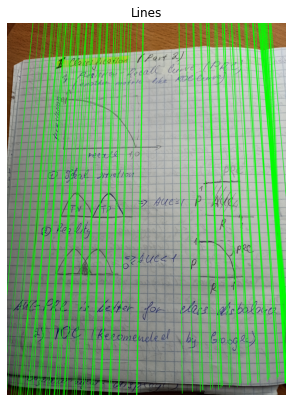

In [5]:
img_copy = img.copy()
lines_points1 = lines_points[r.inliers_mask]
for x1, y1, x2, y2 in lines_points1:
    cv2.line(img_copy, (x1, y1), (x2, y2), (0,255,0),2)
    
    
plt.figure(figsize=(5,10))
plt.clf()
plt.axis("off")
plt.title("Lines")
plt.imshow(img_copy)  

In [6]:
lines_points = lines_points[~r.inliers_mask]
line_group2 = r.get_direction_lines(lines_coefs[~r.inliers_mask])
print(f"lines in group 2: {len(line_group2)}")

lines in group 2: 117


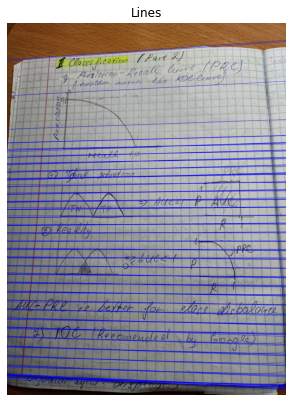

In [7]:
img_copy = img.copy()
lines_points2 = lines_points[r.inliers_mask]
for x1, y1, x2, y2 in lines_points2:
    cv2.line(img_copy, (x1, y1), (x2, y2), (0,0,255),2)
    
    
plt.figure(figsize=(5,10))
plt.clf()
plt.axis("off")
plt.title("Lines")
plt.imshow(img_copy)  